# Vorbereitung

In [1]:
# Libraries laden
suppressWarnings({
suppressMessages({
    library(tidyverse)
    library(lubridate)
    library(graphics)
    library(trend)
    library(ggpubr)
    library(broom)
    library(knitr)
    library(gt)
    library(gtExtras)
 })})

# Plot Voreinstellungen
plot_settings = 
    theme(
        axis.title=element_text(size=20),
        title=element_text(size=20),
        axis.text  = element_text(size=14),
        legend.text = element_text(size = 14)
    )

In [2]:
# Daten Einlesen
detailed <- read.csv("./data/detailed.csv")
general <- read.csv("./data/general.csv")
logger <- read.csv(paste0("./data/logger.csv"))

level_cat <- c('0', '1 - 2', '3 - 5', '6 - 10', '11 - 20', '21 - 50', '50 <')

# Blattläuse an den Salaten

In [4]:
# Aufbereiten der Daten für Tisch 2
detailed %>% 
    filter(
        ref == "r1"
    ) %>%
    mutate(
        date = date(time),
        category = category %>% as.factor() %>% fct_relevel(level_cat),
        category_int = category %>% as.character(),
        values = case_when(
            category_int == '0' ~ 0,
            category_int == '1 - 2' ~ 1.5,
            category_int == '3 - 5' ~ 4,
            category_int == '6 - 10' ~ 8,
            category_int == '11 - 20' ~ 15.5,
            category_int == '21 - 50' ~ 35.5,
            category_int == '50 <' ~ 50
        )
    ) %>%
    select(
        date, table, plant, species, category, values
    ) -> blatt

    blatt %>% group_by(date) %>% summarise(total = sum(values)) -> blatt_sum

verdaprotect = c('2023-03-30', '2023-04-13', '2023-04-27')
before = c("2023-03-27", "2023-04-11", "2023-04-24")
after = c("2023-04-03", "2023-04-19", "2023-05-02")

cbind(
    blatt %>% filter(date %in% as.Date(before)) %>%
    arrange(date, plant)  %>%
    select(table, plant, date_b = date, category_b = category, values_b = values),

    blatt %>% filter(date %in% as.Date(after)) %>% 
    arrange(date, plant) %>%
    select(date_a = date, category_a = category, values_a = values)
) -> before_after

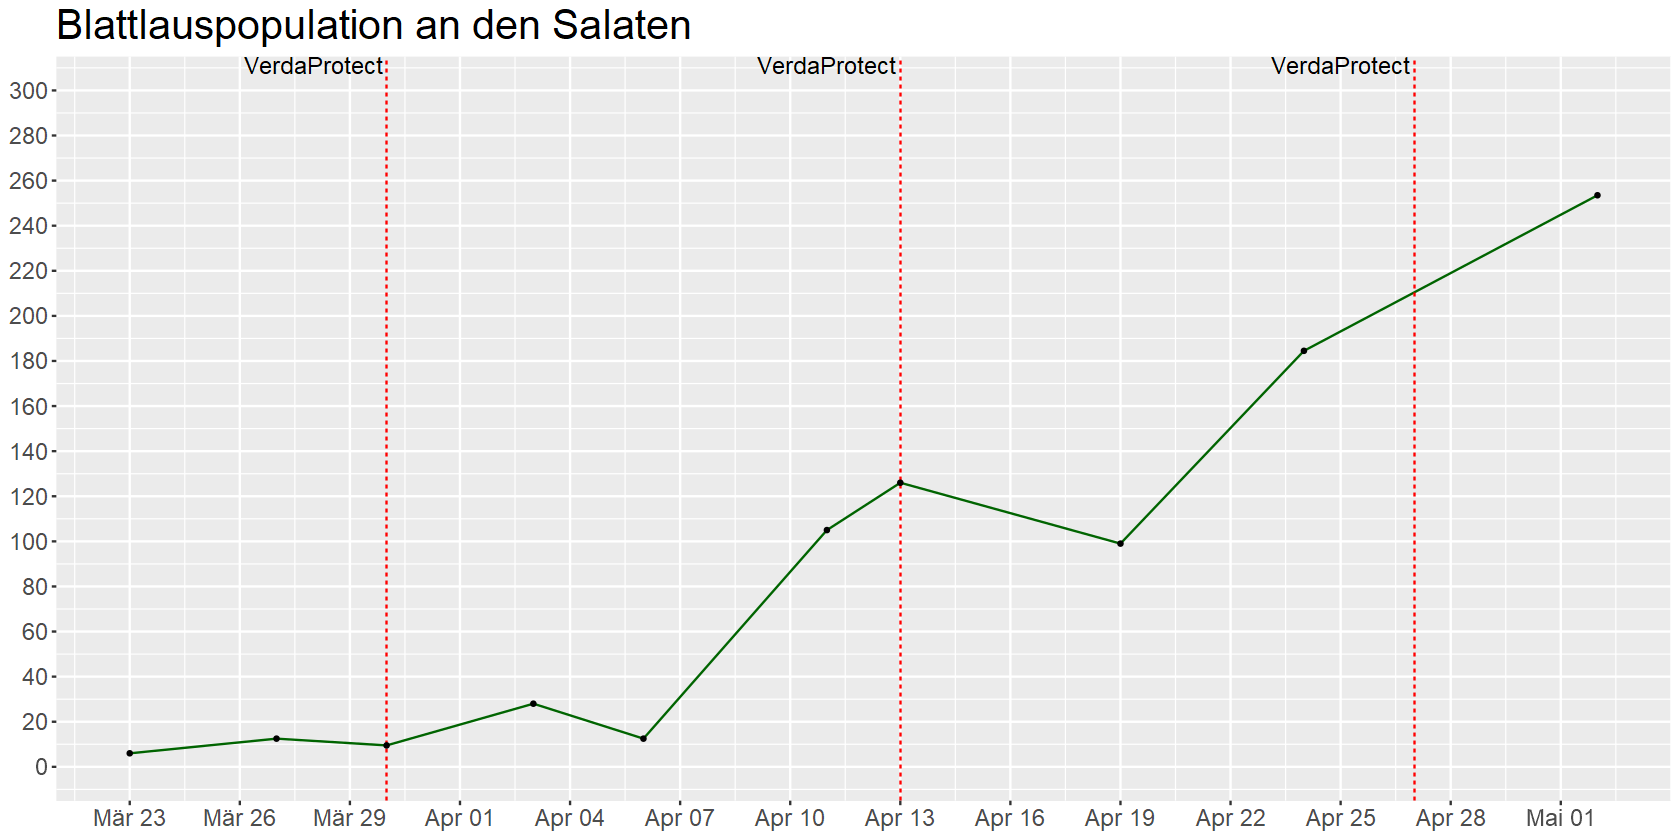

In [30]:
# Grafik Blattlauspopulation an den Salaten
ratio = c(14,7)
options(repr.plot.width = ratio[1], repr.plot.height = ratio[2])

blatt_sum %>%
ggplot(aes(x = date, y = total)) +
    geom_line(color = "darkgreen") +
    geom_vline(
        xintercept = as.Date(verdaprotect),
        linetype = "dashed", color = "red")+
    geom_point(size = 0.8) +
    plot_settings +
        scale_x_date(
            breaks = seq(
                min(blatt_sum$date), 
                max(blatt_sum$date), 
                by = "3 day"), 
            date_labels = "%b %d")+
        scale_y_continuous(
            limits = c(0,300),
            breaks = seq(0,300,20)
        )+
        theme(
            axis.title.x = element_blank(),
            axis.title.y = element_blank())+
        ggtitle("Blattlauspopulation an den Salaten")+
        labs(color = " Pflanze")+
        annotate("text", x = as.Date("2023-03-30")-2, y = Inf, label = "VerdaProtect", vjust = 1, size = 5) +
        annotate("text", x = as.Date("2023-04-13")-2, y = Inf, label = "VerdaProtect", vjust = 1, size = 5) +
        annotate("text", x = as.Date("2023-04-27")-2, y = Inf, label = "VerdaProtect", vjust = 1, size = 5)

ggsave("./output/blattläuse_an_salaten.jpg", width = ratio[1], height = ratio[2], dpi = 600)

In [17]:
# t Test für Änderung vor und nach VerdaProtect
# ausgewählte Daten für t-Test
tibble(
    Vormonitoring = as.Date(before),
    Applikation = as.Date(verdaprotect),
    Nachmonitoring = as.Date(after)
) -> tt_data

tt_data %>%
gt() %>%
tab_header(title = "Daten für t-Test")  %>%
tab_options(table.width = "40%") %>%
gtsave(file = "./output/daten.png")

cat("Datenauswahl für t-Test:")
tt_data

# t-Test: alpha = 0.05

before_after %>% with(t.test(values_b, values_a, paired = TRUE, alternative = "greater")) %>%
tidy() %>%
mutate_if(is.double, round, 3) -> tt_result

tt_result %>%
gt() %>%
tab_header(title = "t-Test VerdaProtect")  %>%
gtsave(file = "./output/table_verda.png")

cat("t-Test VerdaProtect:")
tt_result



Datenauswahl für t-Test:

Vormonitoring,Applikation,Nachmonitoring
<date>,<date>,<date>
2023-03-27,2023-03-30,2023-04-03
2023-04-11,2023-04-13,2023-04-19
2023-04-24,2023-04-27,2023-05-02


t-Test VerdaProtect:

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-2.907,-0.836,0.795,26,-8.841,Inf,Paired t-test,greater


### Klima Tisch 2

In [7]:
# Aufbereiten der Klimadaten auf Tisch 2
logger %>% 
filter(
    table == 2,
    time >= min(blatt$date),
    time <= max(blatt$date)
) %>%
group_by(
    date = date(time)
) %>%
summarise(
    temp_mean = round(mean(temp),1),
    temp_min = min(temp),
    temp_max = max(temp),
    hum_mean = round(mean(hum)),
    hum_min = min(hum),
    hum_max = max(hum)
) -> logger2_summarised

logger2_summarised %>% 
    select(
        date, 
        Mittel = temp_mean, 
        Maximum = temp_max,
        Minimum = temp_min
        ) %>%
        pivot_longer(
            !date,
            names_to = "type", 
            values_to = "temp"
        ) %>%
        mutate(
            type = type %>% as.factor() %>% 
                fct_relevel(c("Maximum", "Mittel", "Minimum"))
        )-> logger2_temp

logger2_summarised %>% select(
        date, 
        Mittel = hum_mean, 
        Maximum = hum_max,
        Minimum = hum_min
        ) %>%
        pivot_longer(
            !date,
            names_to = "type", 
            values_to = "hum"
        ) %>%
        mutate(
            type = type %>% as.factor() %>% 
                fct_relevel(c("Maximum", "Mittel", "Minimum"))
        ) -> logger2_hum 

In [8]:
# Trendtest Temperatur Tisch 2: alpha = 0.05
logger2_temp %>% 
filter(type == "Mittel") %>% 
pull(temp) %>% mk.test() %>% tidy() %>%
mutate_if(is.double, round, 3) -> mk_temp

mk_temp %>%
gt() %>%
tab_header(title = "MK-Trend Test Temperatur")  %>%
gtsave(file = "./output/table_mk_temp.png")

cat("Temperatur:")
mk_temp
cat("")

# Trend Test Feuchtigkeit Tisch 2: alpha = 0.05
logger2_hum %>% 
filter(type == "Mittel") %>% 
pull(hum) %>% mk.test() %>% tidy() %>%
mutate_if(is.double, round, 3) -> mk_hum

mk_hum %>%
gt() %>%
tab_header(title = "MK-Trend Test Feuchtigkeit")  %>%
gtsave(file = "./output/table_mk_hum.png")

cat("Feuchtigkeit:")
mk_hum

Temperatur:

statistic,p.value,parameter,method,alternative
<dbl>,<dbl>,<int>,<chr>,<chr>
2.812,0.005,41,Mann-Kendall trend test,two.sided


Feuchtigkeit:

statistic,p.value,parameter,method,alternative
<dbl>,<dbl>,<int>,<chr>,<chr>
-0.721,0.471,41,Mann-Kendall trend test,two.sided


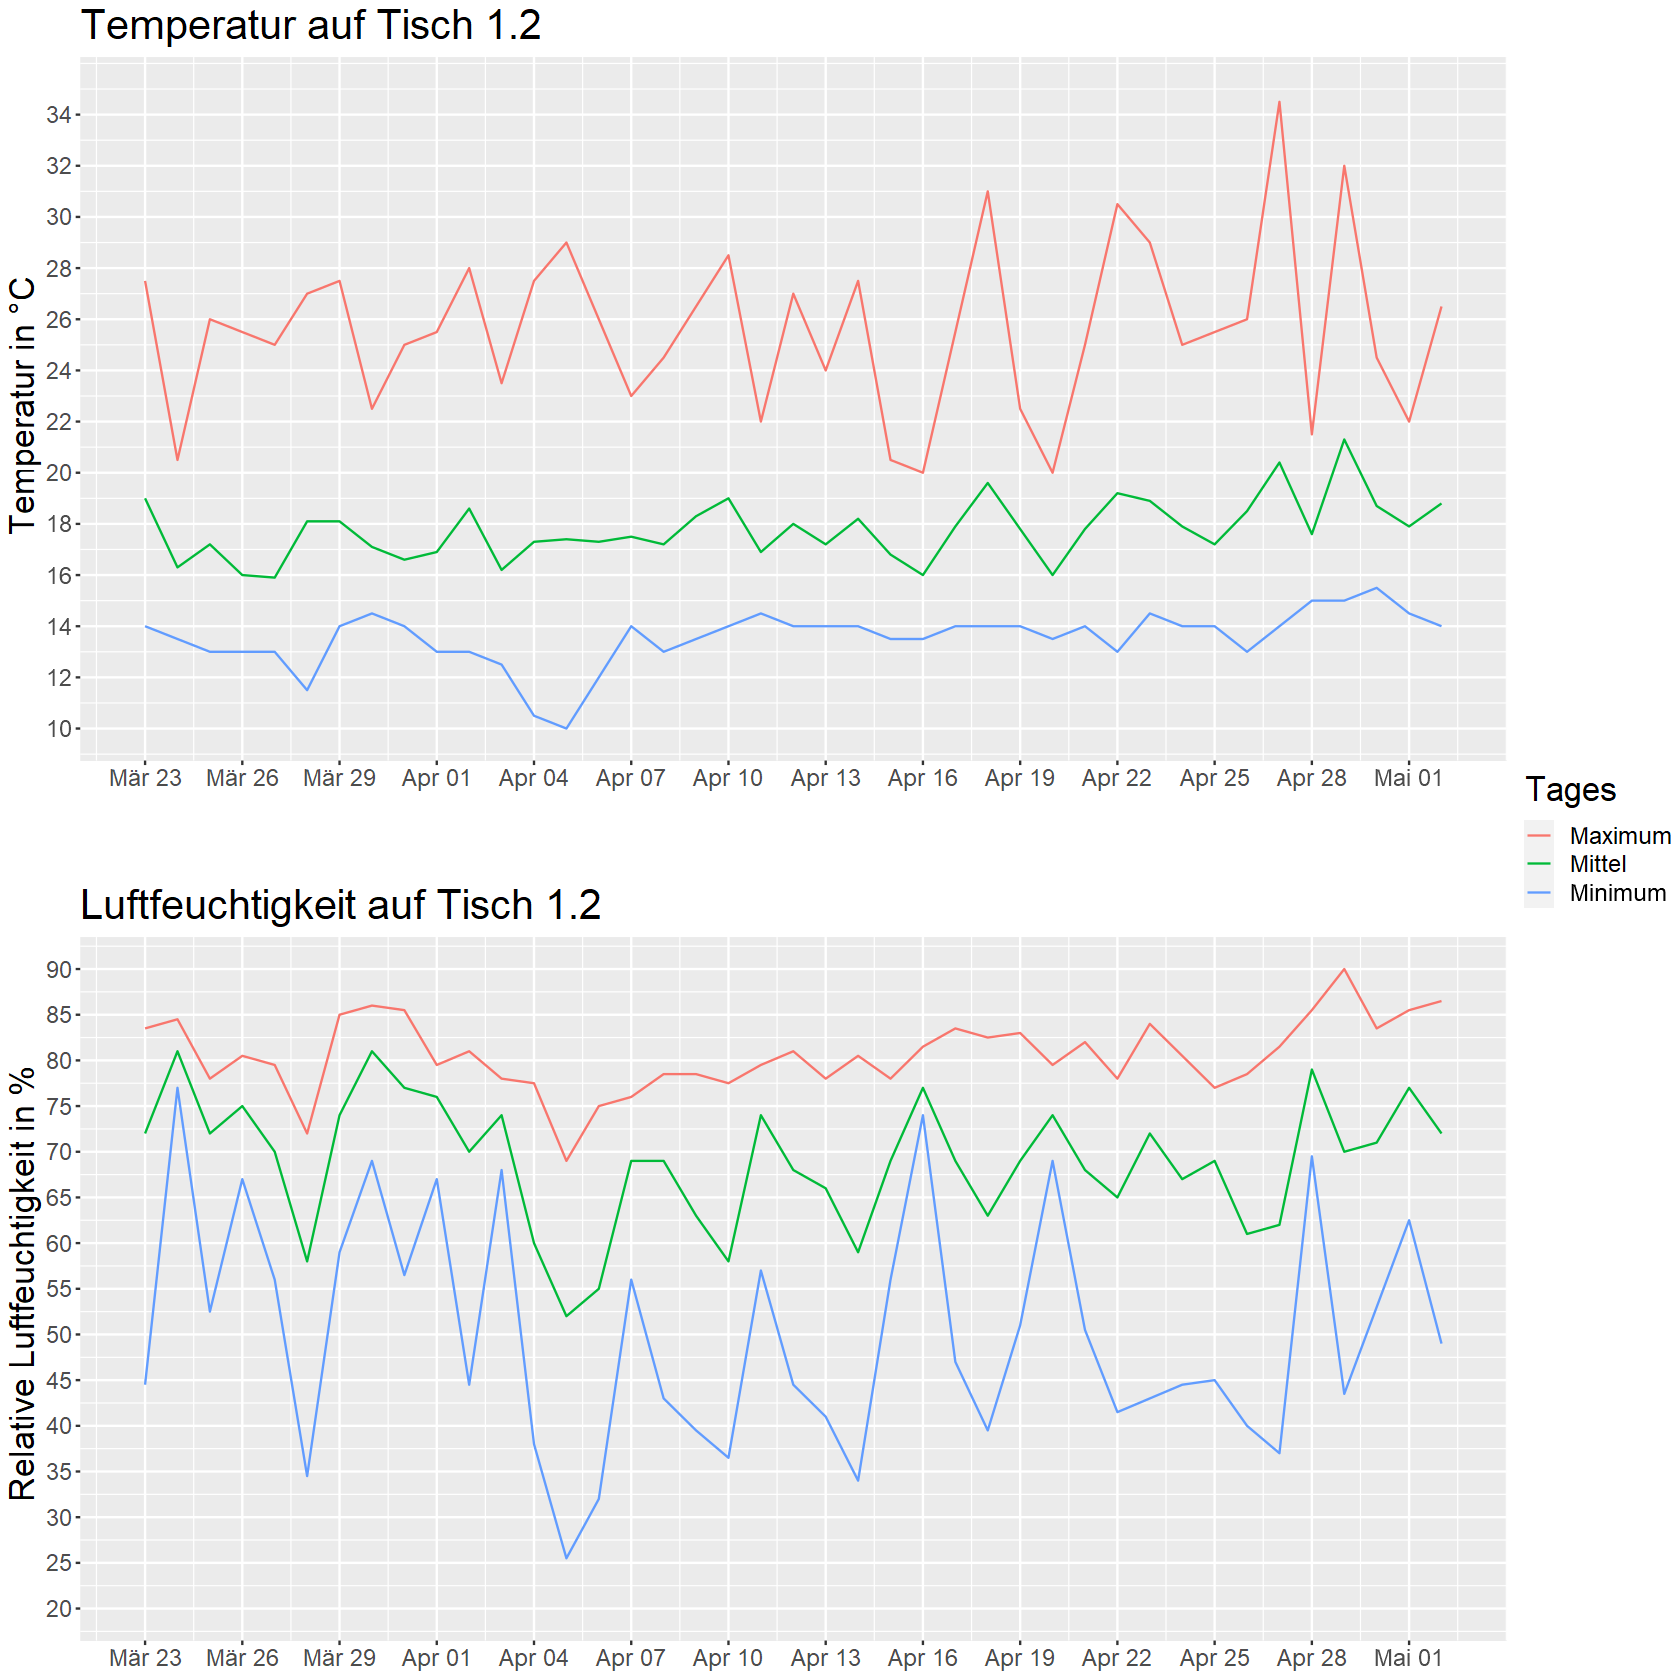

In [32]:
# Grafik Klima auf Tisch 2
ratio = c(14,7)
options(repr.plot.width = ratio[1], repr.plot.height = ratio[2])

plot_temp2 = logger2_temp %>%
ggplot(aes(x = date, y = temp))+
geom_line(aes(group = type, color = type))+
plot_settings +
        scale_x_date(
            breaks = seq(
                min(logger2_temp$date), 
                max(logger2_temp$date), 
                by = "3 day"), 
            date_labels = "%b %d")+
        scale_y_continuous(
            limits = c(10,35),
            breaks = seq(10,35,2)
        )+
        theme(
            axis.title.x = element_blank())+
        ggtitle("Temperatur auf Tisch 1.2")+
        labs(
            color = "Tages",
            y = "Temperatur in °C")
ggsave("./output/temp_tisch2.jpg", width = ratio[1], height = ratio[2], dpi = 600)

            
plot_hum2 = logger2_hum %>%
ggplot(aes(x = date, y = hum))+
geom_line(aes(group = type, color = type))+
plot_settings +
        scale_x_date(
            breaks = seq(
                min(logger2_hum$date), 
                max(logger2_hum$date), 
                by = "3 day"), 
            date_labels = "%b %d")+
        scale_y_continuous(
            limits = c(20,90),
            breaks = seq(20,90,5)
        )+
        theme(
            axis.title.x = element_blank())+
        ggtitle("Luftfeuchtigkeit auf Tisch 1.2")+
        labs(
            color = "Tages",
            y = "Relative Luftfeuchtigkeit in %")
ggsave("./output/hum_tisch2.jpg", width = ratio[1], height = ratio[2], dpi = 600)

# combined plot
empty <- ggplot() + theme_void()
final_plot <- ggarrange(plot_temp2, empty, plot_hum2, nrow = 3, common.legend = TRUE, legend = "right",heights = c(1, 0.1, 1))

ratio = c(14,14)
options(repr.plot.width = ratio[1], repr.plot.height = ratio[2])
final_plot
ggsave("./output/klima_tisch2.jpg", width = ratio[1], height = ratio[2], dpi = 600)

# Klima Tischgruppe 2

In [10]:
# Aufbereiten der Klimadaten auf Tischgruppe 2
logger %>% 
filter(
    table %in% c(5,6,7,8),
) %>%
group_by(
    table,
    date = date(time)
) %>%
summarise(
    temp_mean = round(mean(temp),1),
    temp_min = min(temp),
    temp_max = max(temp),
    hum_mean = round(mean(hum)),
    hum_min = min(hum),
    hum_max = max(hum)
) -> logger_summarised

logger_summarised %>% 
    select(
        date,
        table, 
        Mittel = temp_mean, 
        Maximum = temp_max,
        Minimum = temp_min
        ) %>%
    pivot_longer(
        cols = c(-date, -table),
        names_to = "type", 
        values_to = "temp") -> logger_temp

logger_summarised %>% 
    select(
        date,
        table,
        Mittel = hum_mean, 
        Maximum = hum_max,
        Minimum = hum_min
        ) %>%
    pivot_longer(
        cols = c(-date, -table),
        names_to = "type", 
        values_to = "hum") -> logger_hum

`summarise()` has grouped output by 'table'. You can override using the
`.groups` argument.


In [11]:
# Anova Test für Temperatur auf Tischgruppe 2: alpha = 0.05
aov(temp ~ table, data = logger %>% filter(table %in% 5:8)) %>% 
tidy() -> aov_temp

aov_temp %>%
mutate_if(is.double, round, 3) %>%
gt() %>%
tab_header(title = "Anova Test Temperatur") %>%
gtsave(file = "./output/table_avn_temp.png")

cat("Temperatur:")
aov_temp
cat("")

# Anova Test für die Feuchtigkeit auf Tischgruppe 2: alpha = 0.05
aov(hum ~ table, data = logger %>% filter(table %in% 5:8)) %>% 
tidy() -> aov_hum

aov_hum %>%
mutate_if(is.double, round, 3) %>%
gt() %>%
tab_header(title = "Anova Test Feuchtigkeit")  %>%
gtsave(file = "./output/table_avn_hum.png")

cat("Feuchtigkeit:")
aov_hum

Temperatur:

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
table,1,19.7748,19.77480,1.13496,0.2867324
Residuals,20406,355540.6998,17.42334,NA,NA


Feuchtigkeit:

term,df,sumsq,meansq,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
table,1,9.152426e+01,91.52426,0.5580269,0.4550649
Residuals,20406,3.346871e+06,164.01406,NA,NA


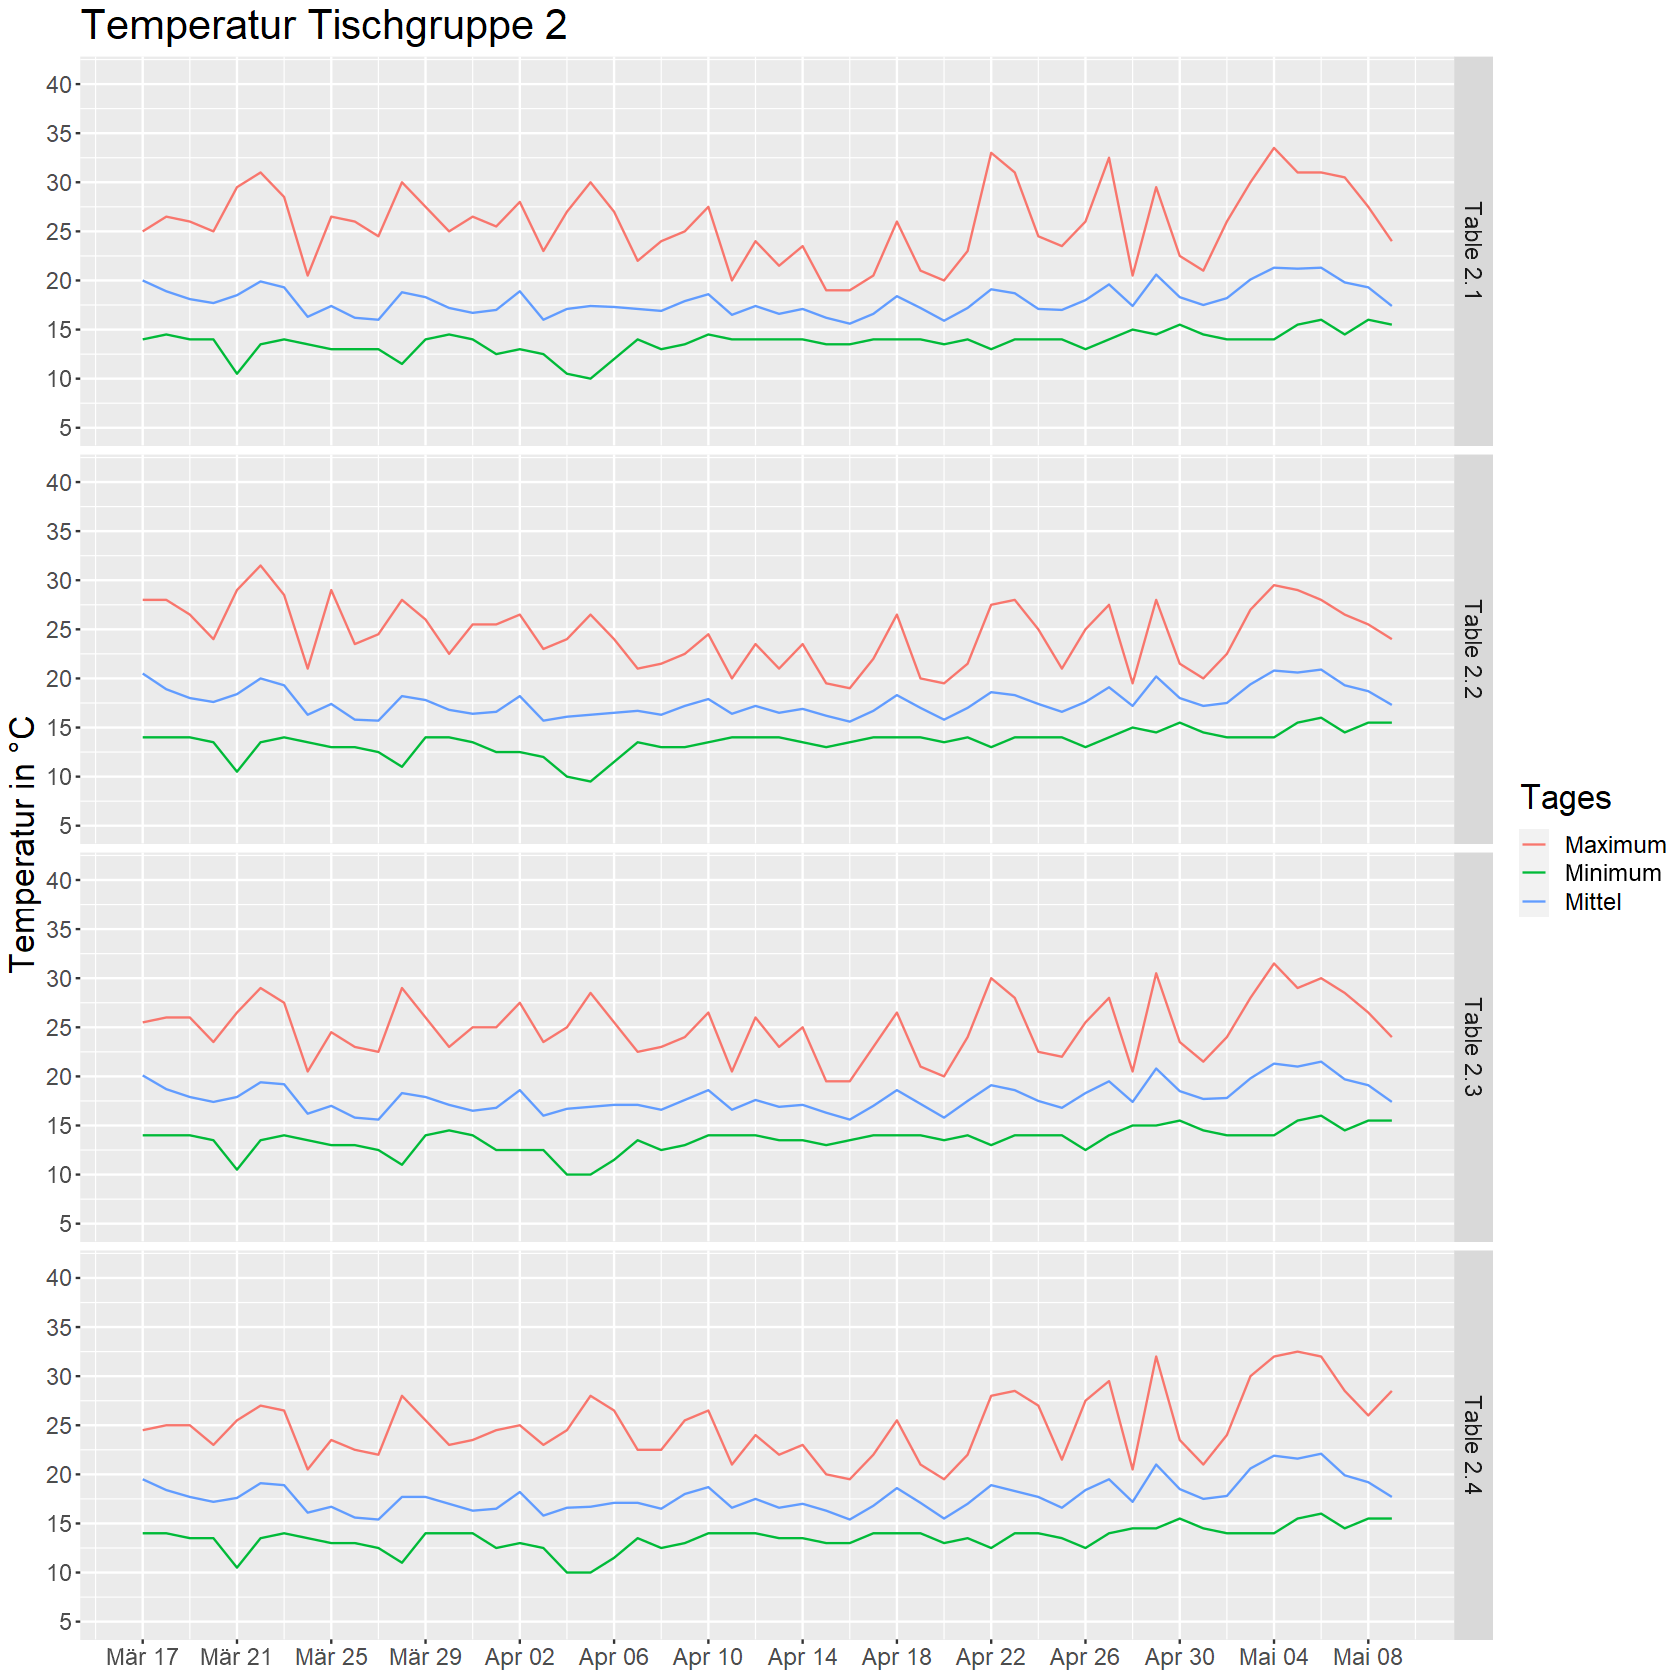

In [24]:
# Grafik Temperatur auf Tischgruppe 2
ratio = c(14,14)
options(repr.plot.width = ratio[1], repr.plot.height = ratio[2])

logger_temp %>%
ggplot(aes(x = date, y = temp))+
geom_line(aes(group = type, color = type))+
plot_settings +
        scale_x_date(
            breaks = seq(
                min(logger_temp$date), 
                max(logger_temp$date), 
                by = "4 day"), 
            date_labels = "%b %d")+
        scale_y_continuous(
            limits = c(5,41),
            breaks = seq(5,41,5)
        )+
        theme(
            axis.title.x = element_blank(),
            strip.text = element_text(size = 14, face = "bold"))+
        ggtitle("Temperatur Tischgruppe 2")+
        labs(
            color = "Tages",
            y = "Temperatur in °C")+
facet_grid(rows=vars(table), labeller = label_bquote("Table 2." * .(as.character(table-4))))
ggsave("./output/temperatur_tisch_gruppe2.jpg", width = ratio[1], height = ratio[2], dpi = 600)

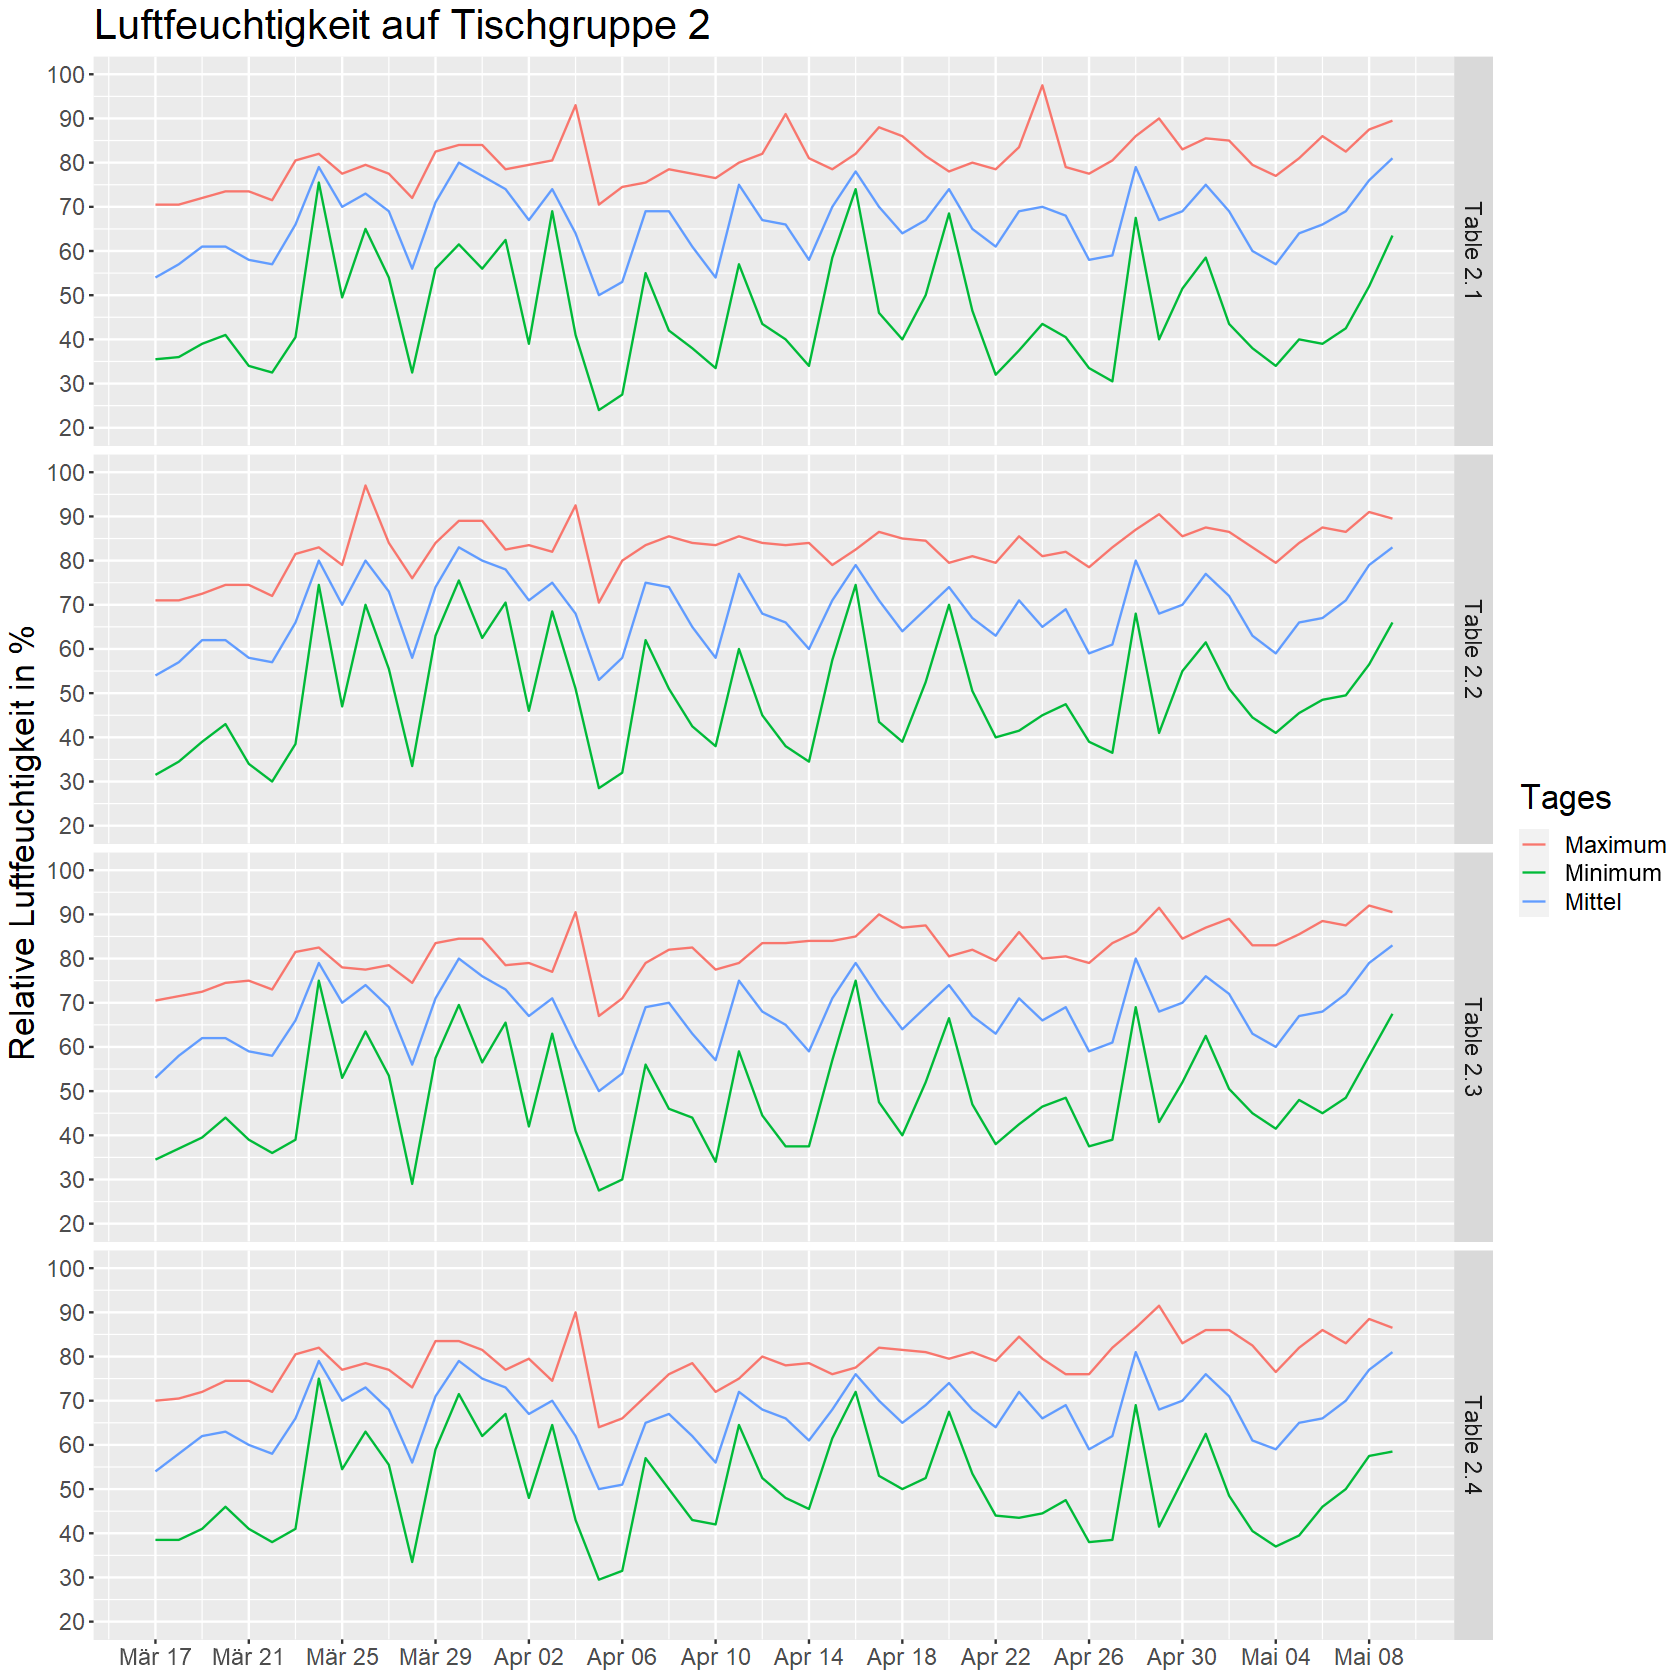

In [25]:
# Grafik Feuchtigkeit auf Tischgruppe 2
ratio = c(14,14)
options(repr.plot.width = ratio[1], repr.plot.height = ratio[2])

logger_hum %>%
ggplot(aes(x = date, y = hum))+
geom_line(aes(group = type, color = type))+
plot_settings +
        scale_x_date(
            breaks = seq(
                min(logger_hum$date), 
                max(logger_hum$date), 
                by = "4 day"), 
            date_labels = "%b %d")+
        scale_y_continuous(
            limits = c(20,100),
            breaks = seq(20,100,10)
        )+
        theme(
            axis.title.x = element_blank(),
            strip.text = element_text(size = 14, face = "bold"))+
        ggtitle("Luftfeuchtigkeit auf Tischgruppe 2")+
        labs(
            color = "Tages",
            y = "Relative Luftfeuchtigkeit in %")+
facet_grid(rows=vars(table), labeller = label_bquote("Table 2." * .(as.character(table-4))))
ggsave("./output/feuchtigkeit_tisch_gruppe2.jpg", width = ratio[1], height = ratio[2], dpi = 600)